In [3]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import random
import networkx as nx

Ising Model MCMC Simulation:

In [4]:
# create n x n board with n^2*p nodes assigned -1 and the rest 1
def gen_board(n, p):
    B = np.ones(n*n)
    B[1:math.floor(n*n*p)] = -1
    np.random.shuffle(B)
    B = B.reshape((n,n))
    return B

In [5]:
def draw_board(B):
    cmap = mpl.colors.ListedColormap(['white', 'black'])
    plt.imshow(B, cmap=cmap, interpolation='none') 

In [6]:
def bond_energy(x, B, n):
    i = x[0]
    j = x[1]
    up    = B[i-1, j] if (i > 0) else 0
    down  = B[i+1, j] if (i < n-1) else 0
    left  = B[i, j-1] if (j > 0) else 0
    right = B[i, j+1] if (j < n-1) else 0
    sum_of_neighbors = up + down + left + right
    return -B[i,j] * sum_of_neighbors

In [7]:
def total_energy(B, n):
    E = 0
    for i in range(n):
        for j in range(n):
            E += bond_energy((i,j), B, n)/2
    return E

In [8]:
def energy_diff_from_swap(x, y, B, n):
    return -2 * (bond_energy(x, B, n) + bond_energy(y, B, n))

In [9]:
def are_adjacent(x, y, n):
    i1 = x[0]
    i2 = y[0]
    i_diff1 = abs(i1 - i2)
    i_diff2 = n - i_diff1
    i_diff = min(i_diff1, i_diff2)
    
    j1 = x[1]
    j2 = y[1]
    j_diff1 = abs(j1 - j2)
    j_diff2 = n - j_diff1
    j_diff = min(j_diff1, j_diff2)
    
    return (i_diff == 0 and j_diff == 1) or (i_diff == 1 and j_diff == 0)

In [10]:
def swap(x, y, B):
    temp = B[x[0], x[1]]
    B[x[0], x[1]] = B[y[0], y[1]]
    B[y[0], y[1]] = temp

In [11]:
n = 18 # board size
p = 0.4 # proportion of states which are spin up
E = None
E_history = []

def metropolis_update(B, n, t):
    global E
    x = np.random.choice(n, 2)
    y = np.random.choice(n, 2)
    if (B[x[0], x[1]] == B[y[0], y[1]]) or are_adjacent(x, y, n): # retry if two positions have same spin or are adjacent
        return metropolis_update(B, n, t)
    dE = energy_diff_from_swap(x, y, B, n)
    if dE <= 0 or (np.random.rand() < math.exp(-dE / t)):
        swap(x, y, B)
        E += dE
        E_history.append(E)

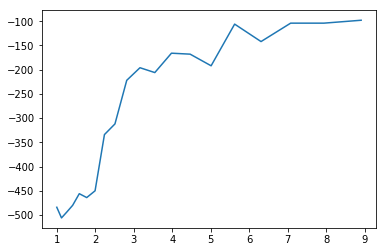

In [65]:
num_iterations = 10000
temps = []
configs = []
energies = []

for a in np.arange(0, 1, 0.05):
    t = 10**a
    B = gen_board(n, p)
    E = total_energy(B, n)
    E_history = [E]
    for j in range(num_iterations):
        metropolis_update(B, n, t)
    temps.append(t)
    configs.append(B)
    energies.append(E)
plt.plot(temps, energies)

Districting MCMC Search

In [30]:
# create n x n square grid graph
def create_square_grid_graph(n, diagonals):
    G = nx.Graph()
    for i in range(n ** 2):
        # the nodes are indexed row first (1st row is indices 0 through 9, 2nd row is indices 10 through 19, etc.)
        row = i // n # result of division is floored
        col = i % n
        # compute indices of relevant adjacent nodes and add edges
        # no need to add W, N, NE, NW because we already visited those nodes
        east  = i + 1
        south = i + n
        if row < n - 1:
            G.add_edge(i, south)
        if col < n - 1:
            G.add_edge(i, east)
        if diagonals:
            southwest = i + n - 1
            southeast = i + n + 1
            if row < n - 1 and col > 0:
                G.add_edge(i, southwest)
            if row < n - 1 and col < n - 1:
                G.add_edge(i, southeast)
    return G

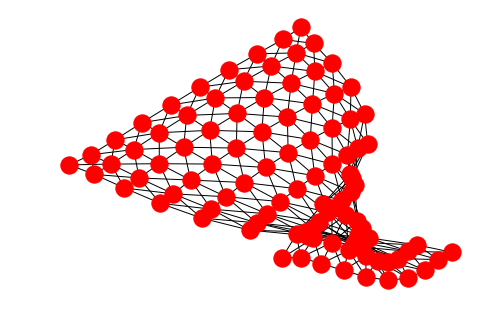

In [14]:
# test create_square_grid_graph_with_diagonals
nx.draw(create_square_grid_graph(10, True))

In [15]:
# create an initial block-layout districting
def create_block_districting(block_width, block_height, num_blocks_across, num_blocks_down):
    num_vertices_across = block_width * num_blocks_across
    num_vertices_down = block_height * num_blocks_down
    num_vertices = num_vertices_across ** 2
    districting = np.zeros(num_vertices)
    for i in range(num_vertices):
        row = i // num_vertices_down
        col = i % num_vertices_across
        block_row = row // block_height
        block_col = col // block_width
        block_index = block_row * num_blocks_across + block_col
        districting[i] = block_index
    return districting

In [16]:
# test create_block_districting
create_block_districting(2, 2, 2, 2)

array([0., 0., 1., 1., 0., 0., 1., 1., 2., 2., 3., 3., 2., 2., 3., 3.])

In [17]:
# change the district of the second node to that of the first
def flip_district(districting, node1, node2, district_sizes):
    district_sizes[int(districting[node1])] += 1
    district_sizes[int(districting[node2])] -= 1
    districting[node2] = districting[node1]

In [18]:
# test flip_district
d = [0, 1]
district_sizes = [1, 1]
flip_district(d, 0, 1, district_sizes)
print(d)
print(district_sizes)

[0, 0]
[2, 0]


In [19]:
# remove all edges connected to vertex v in graph G
def remove_edges_from_vertex(G, v):
    neighbors = list(nx.all_neighbors(G, v))
    for neighbor in neighbors:
        G.remove_edge(v, neighbor)

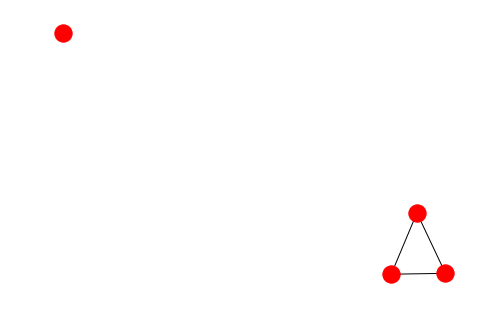

In [20]:
# test remove_edges_to_neighbors
G = create_square_grid_graph(2, diagonals=True)
remove_edges_from_vertex(G, 0)
nx.draw(G)

In [21]:
# look at edges from vertex v in graph G_full
# and add to graph G_d those which connect v to a vertex
# in the same district, according to the district list
def connect_vertex_to_neighbors_in_district(G_d, v, districting, G_full):
    neighbors = list(nx.all_neighbors(G_full, v))
    for neighbor in neighbors:
        if districting[v] == districting[neighbor]:
            G_d.add_edge(v, neighbor)

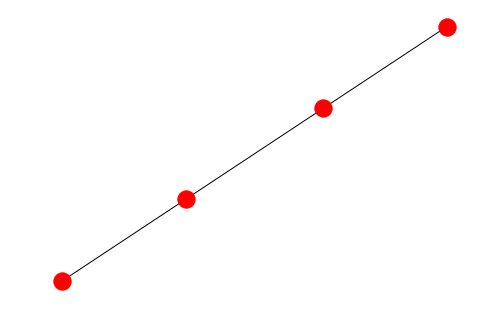

In [22]:
# test connect_vertex_to_neighbors_in_district
G_full = create_square_grid_graph(2, diagonals=True)
G_d = nx.Graph()
G_d.add_edge(0,1)
G_d.add_edge(2,3)
districting = [0,0,0,1]
connect_vertex_to_neighbors_in_district(G_d, 0, districting, G_full)
nx.draw(G_d)
# result should be path on four vertices

In [23]:
# create subgraph of G w/ edges only between vertices in same district
def create_district_subgraph(G, districting):
    G_d = G.copy()
    G_d_edges = list(G_d.edges())
    for edge in G_d_edges:
        v1 = edge[0]
        v2 = edge[1]
        if districting[v1] != districting[v2]:
            G_d.remove_edge(v1, v2)
    return G_d

In [24]:
def update_district_subgraph_after_swap(G, G_d, v1, v2, new_districting):
    remove_edges_from_vertex(G_d, v1)
    remove_edges_from_vertex(G_d, v2)
    connect_vertex_to_neighbors_in_district(G_d, v1, current_districting, G)
    connect_vertex_to_neighbors_in_district(G_d, v2, current_districting, G)

In [68]:
# create initial districting plan by placing 2*3 block grid over 18x18 grid graph
block_width = 9
block_height = 6
num_blocks_across = 2
num_blocks_down = 3

num_vertices_across = block_width * num_blocks_across
num_districts = num_blocks_across * num_blocks_down
nodes_per_district = block_width * block_height
num_districts = num_blocks_across * num_blocks_down

G = create_square_grid_graph(num_vertices_across, diagonals=False)
G_edges = list(G.edges())
num_G_edges = len(G_edges) # number of edges in the grid graph

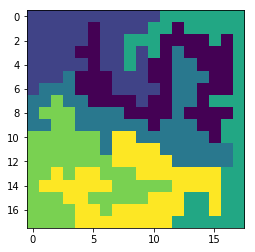

In [71]:
num_proposals = 50000
current_districting = create_block_districting(block_width, block_height, num_blocks_across, num_blocks_down)
districtings = [current_districting]

# Find the initial size of each district
district_sizes = [0] * num_districts
for i in current_districting:
    district_sizes[int(i)] += 1

# G_d (G_district) is the subgraph of G where edges connect nodes in the same district
# G_d should have one connected component per district
G_d = create_district_subgraph(G, current_districting)

for k in range(num_proposals):
    # search for conflicting edge to swap]
    
    num_tries = 0
    still_searching = True
    while still_searching: # Each edge occurs twice in the edge list; a-b and b-a
        num_tries += 1
        r = random.randint(0, num_G_edges - 1)
        edge = G_edges[r]
        
        r2 = random.randint(0,1)
        
        if r2 == 0:
            v1 = edge[0]
            v2 = edge[1]
        else:
            v1 = edge[1]
            v2 = edge[0]
        
        if district_sizes[int(current_districting[v1])] > nodes_per_district:
            continue
        if district_sizes[int(current_districting[v2])] < nodes_per_district:
            continue
        if current_districting[v1] != current_districting[v2]:
            still_searching = False

    # save the original district of v2 in case the flip isn't accepted
    # flip the district of v2 to that of v1
    # update the district graph G_d:
    # - remove all edges connected to v1 or v2
    # - add edges to v1 or v2 based on new districting
    old_v2 = current_districting[v2]
    flip_district(current_districting, v1, v2, district_sizes)
    update_district_subgraph_after_swap(G, G_d, v1, v2, current_districting)
    
    # if the new districting is valid, add it to the list
    # otherwise undo the changes
    if nx.number_connected_components(G_d) == num_districts:
        districting_copy = copy.deepcopy(current_districting) # without a deep copy, updating the current districting would change those already stored in the districtings list
        districtings.append(districting_copy)
    else:
        current_districting[v2] = old_v2
        district_sizes[int(current_districting[v2])] += 1
        district_sizes[int(current_districting[v1])] -= 1
        update_district_subgraph_after_swap(G, G_d, v1, v2, current_districting)
plt.imshow(current_districting.reshape((18,18)))

In [73]:
# get unique districtings, not identifying those which labels permuted
unique_districtings = [np.array(x) for x in set(tuple(x) for x in districtings)]
print(str(len(districtings)) + ' districtings found.')
print(str(len(unique_districtings)) + ' unique districtings found.')

36653 districtings found.
36034 unique districtings found.


Seat Share Calculations

In [74]:
def get_seat_share(config, districting):
    config_flat = np.reshape(config, len(districting))
    num_districts = int(max(districting)) + 1
    seats = 0
    for d in range(num_districts):
        vote_diff = sum(config_flat[districting == d])
        if vote_diff < 0:
            seats += 1
        elif vote_diff == 0:
            seats += 0.5
    return seats

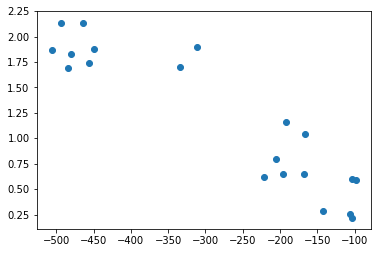

In [75]:
seats = []
for config in configs:
    avg_seats = 0
    for districting in unique_districtings:
        avg_seats += get_seat_share(config, districting)
    avg_seats /= float(len(unique_districtings))
    seats.append(avg_seats)
plt.scatter(energies, seats)

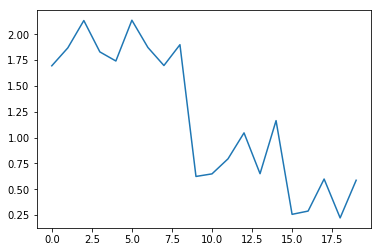

In [76]:
plt.plot(seats)

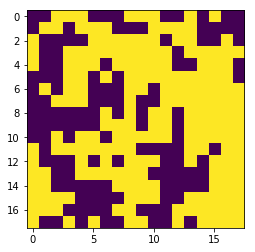

In [63]:
plt.imshow(configs[12])

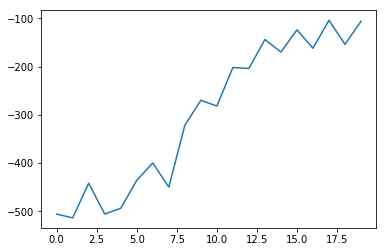

In [64]:
plt.plot(energies)

In [28]:
current_districting

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       1., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       2., 4., 4., 4., 5.

In [29]:
district_sizes

[55, 55, 55, 53, 53, 53]

In [33]:
G_rook.number_of_edges()

612

In [34]:
G_rook.edges()

EdgeView([(0, 18), (0, 1), (18, 36), (18, 19), (1, 19), (1, 2), (19, 37), (19, 20), (2, 20), (2, 3), (20, 38), (20, 21), (3, 21), (3, 4), (21, 39), (21, 22), (4, 22), (4, 5), (22, 40), (22, 23), (5, 23), (5, 6), (23, 41), (23, 24), (6, 24), (6, 7), (24, 42), (24, 25), (7, 25), (7, 8), (25, 43), (25, 26), (8, 26), (8, 9), (26, 44), (26, 27), (9, 27), (9, 10), (27, 45), (27, 28), (10, 28), (10, 11), (28, 46), (28, 29), (11, 29), (11, 12), (29, 47), (29, 30), (12, 30), (12, 13), (30, 48), (30, 31), (13, 31), (13, 14), (31, 49), (31, 32), (14, 32), (14, 15), (32, 50), (32, 33), (15, 33), (15, 16), (33, 51), (33, 34), (16, 34), (16, 17), (34, 52), (34, 35), (17, 35), (35, 53), (36, 54), (36, 37), (37, 55), (37, 38), (38, 56), (38, 39), (39, 57), (39, 40), (40, 58), (40, 41), (41, 59), (41, 42), (42, 60), (42, 43), (43, 61), (43, 44), (44, 62), (44, 45), (45, 63), (45, 46), (46, 64), (46, 47), (47, 65), (47, 48), (48, 66), (48, 49), (49, 67), (49, 50), (50, 68), (50, 51), (51, 69), (51, 52),

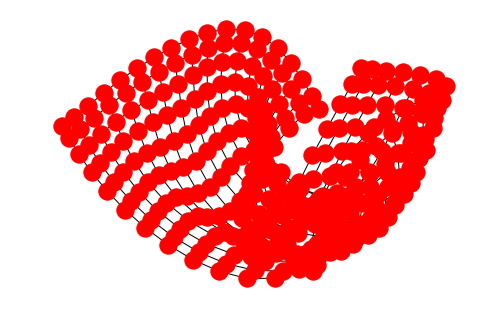

In [35]:
nx.draw(G_rook)